# Object-Scene Scaling Analysis

In [1]:
import numpy as np
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import sem


### Exclusion Criteria
 - Accuracy: 70 % (17/24 correct)
 - RT: Exclude trial if < 250 ms or > 2s
 - Remove participant if more than 10% of the data is removed (?) 
    

### Pilot Analysis Plots

1. Overall Accuracy
    - accuracy by scene category
    - accuracy by zoom 
    - accuracy by zoom x match
2. RT Distribution
    - RT by scene category
    - RT by zoom 
    - RT by zoom x match
3. 2x3 ANOVA
 

In [2]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    
    exclude = []
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

                
        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame

In [3]:
# data_path = '/Users/prachi/Documents/object_scene_scaling_data/pilot2'

data_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/OSS_MTurk/data'

In [4]:
input_data = combineCSVs(data_path)

Number of participants before cleaning:  70


In [5]:
# input_data

In [6]:
num_trials = 16

In [7]:
def cleanbyPracticeTries(df, num_allowed_tries):
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_practice_tries = cleaned_subj_df.pracTries.unique()[0]
        
        if subj_num_practice_tries > num_allowed_tries:
            remove.append(subj)
        else:  
            df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print('Number of participants with more than ' + str(num_allowed_tries) + ' practice tries:', len(remove))
    
    return df2
    

In [8]:
pracTries_cleaned_data = cleanbyPracticeTries(input_data, 3)

Number of participants with more than 3 practice tries: 19


In [9]:
len(pracTries_cleaned_data.subjID.unique())

51

In [10]:
def Accuracy_Cleaning(df, accuracy_threshold, num_trials):
    """    
    Remove participants with overall accuracy below the accuracy threshold (e.g. 0.7)
    
    Returns:
        data of participants that passed the accuracy threshold 
        list of the number of correct trials each participant got
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    list_trials_correct = []
    # number of participants where exclusion is because all responses were 'none'
    c = 0
    
    for subj in all_subjIDs:
        keypresses = []

        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_correct_trials = 0
        
        acc_column = np.array(list(subj_df['accuracy']))
        sum_acc = np.sum(acc_column)
        
        
        for idx, row in subj_df.iterrows():
            trial_acc = row['accuracy']
            if trial_acc == 1:
                subj_num_correct_trials += 1
            else:
                keypresses.append(row['keyPress'])
        
        subj_acc = sum_acc/num_trials
#         print(acc_column)
#         print(subj, sum_acc, subj_acc)
                
        # minimum number of trials correct the participant must have to be included
        if subj_acc < accuracy_threshold:
#             print(subj_acc, subj)
            remove.append(subj)
#             print(len([x for x in keypresses if x == 'none']))
            if len([x for x in keypresses if x == 'none']) >= 4:
                c += 1
        
        list_trials_correct.append(subj_num_correct_trials)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    
    print("Number of Participants with accuracy below 70%: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
                
    print('Number of participants that did not respond for 4 or more trials:', c)
    
    print('Number of participants left: ', len(df2.subjID.unique()))
                
    return df2, list_trials_correct, keypresses

In [11]:
Accuracy_cleaned_data, correct_trials_distribution, keypresses = Accuracy_Cleaning(pracTries_cleaned_data, 0.7, num_trials)


Number of Participants with accuracy below 70%:  23
Number of participants that did not respond for 4 or more trials: 0
Number of participants left:  28


In [12]:
def RT_Cleaning(df, outlier_range, num_trials):
    """
    Remove trials where trial RT is outside of the defined outlier range 
    
    Returns:
        dataframe with outlier RT trials removed
        list of all RTs 
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    print(len(all_subjIDs))
    
    remove = []
    df2_list = []
    total_RT_outliers = 0
    total = 0
    list_trialRT = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        for idx, row in subj_df.iterrows():
            total += 1
            RT = row["RT"]
            list_trialRT.append(RT)
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print(len(df2.subjID.unique()))
                
    return df2, list_trialRT

In [13]:
RT_cleaned_data, trialRTs_distribution = RT_Cleaning(Accuracy_cleaned_data, [250, 2000], num_trials)


28
28


In [14]:
all_subjIDs = RT_cleaned_data.subjID.unique()
dist = []
for subj in all_subjIDs:
    count = 0
    subj_df = RT_cleaned_data.loc[RT_cleaned_data['subjID'] == subj]
    dist.append(len(subj_df))
#     print(len(subj_df))

In [15]:
len([d for d in dist if d >11])

22

In [16]:
# pracTries_cleaned_data.subjID.unique(), RT_cleaned_data.subjID.unique()

In [17]:
def finalTrialCountCheck(df, num_trials, min_trials):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        if count_trials < min_trials:
            remove.append(subj)
            
#         threshold_trials_remaining = num_trials - math.floor(num_trials * 0.1)

#         if count_trials <= threshold_trials_remaining:
#             remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
            
    for subj in remove:
        df.drop(df[df['subjID'] == subj].index, inplace = True) 
                    
    print("Number of participants left: ",len(df.subjID.unique()))
    return df

In [18]:
finalTrialCount_data = finalTrialCountCheck(RT_cleaned_data, num_trials, 12)

Number of Participants with >= 10% trials removed:  6
Number of participants left:  22


In [19]:
np.sum(np.array(finalTrialCount_data['accuracy']))/len(np.array(finalTrialCount_data['accuracy']))

0.8480243161094225

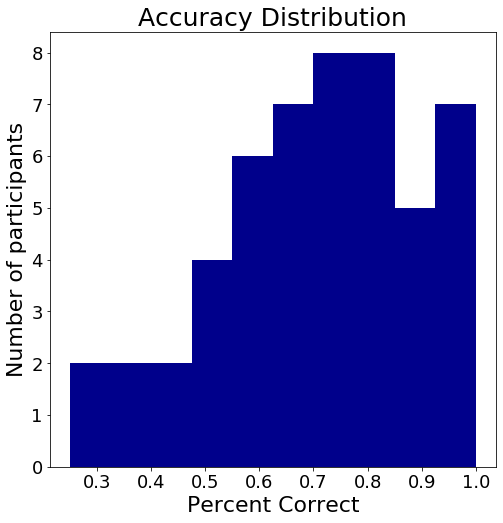

In [20]:
plt.figure(figsize=[8,8])
plt.hist((np.array(correct_trials_distribution))/num_trials, color='darkblue')
# plt.yticks(np.arange(1,3))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Accuracy Distribution', fontsize=25)
plt.xlabel('Percent Correct', fontsize=22)
plt.ylabel('Number of participants', fontsize=22)
plt.show()

In [21]:
final_data = finalTrialCount_data.copy(deep=True)
len(finalTrialCount_data.subjID.unique())

22

In [22]:
def get_misscaled_trials(df):
    """
    args:
        df  
    returns:
        array of misscaled/scaled
    """
    misscaled_col = []
    
    for idx, row in df.iterrows():
        if row['scene1ZoomName'] == 'zo' and row['objectSize']=='small':
            misscaled_col.append('misscaled')

        if row['scene1ZoomName'] == 'zi' and row['objectSize']=='large':
            misscaled_col.append('misscaled')
            
        if row['scene1ZoomName'] == 'zo' and row['objectSize']=='large':
            misscaled_col.append('scaled')

        if row['scene1ZoomName'] == 'zi' and row['objectSize']=='small':
            misscaled_col.append('scaled')
            
            
            
    
    return np.array(misscaled_col)

In [23]:
misscaled_column = get_misscaled_trials(final_data)

# # add misscaled column to dataframe 
final_data.insert(14, "misscaled", misscaled_column)


In [24]:
final_data.to_csv('e3v1_data_5-10-HEYYYYYYYY.csv', index=False)

In [25]:
len(final_data.subjID.unique())

22

## Accuracy


add error bars
- overall accuracy per subj in each condition 

In [26]:
# data split by object-scene size congruency aka scene zoom 

zo_df = final_data.loc[final_data['scene1ZoomName']=='zo']
zi_df = final_data.loc[final_data['scene1ZoomName']=='zi']

zo_acc = np.sum(np.array(zo_df['accuracy']))/len(np.array(zo_df['accuracy']))
zi_acc = np.sum(np.array(zi_df['accuracy']))/len(np.array(zi_df['accuracy']))

zo_acc, zi_acc

(0.8303030303030303, 0.8658536585365854)

In [27]:
misscaled_zo = zo_df.loc[zo_df['misscaled'] =='misscaled'] 
misscaled_zi = zi_df.loc[zi_df['misscaled'] =='misscaled']
misscaled = misscaled_zo.append(misscaled_zi)

scaled_zo = zo_df.loc[zo_df['misscaled'] =='scaled'] 
scaled_zi = zi_df.loc[zi_df['misscaled'] =='scaled']
scaled = scaled_zo.append(scaled_zi)

misscaled_acc = np.sum(np.array(misscaled['accuracy']))/len(np.array(misscaled['accuracy']))
scaled_acc = np.sum(np.array(scaled['accuracy']))/len(np.array(scaled['accuracy']))

misscaled_acc, scaled_acc

(0.8363636363636363, 0.8597560975609756)

In [28]:
# object scene semantic congruency 
# var = objectScene1SemanticCongruency
# acc = np.sum(np.array(misscaled_zo_objSemCong['accuracy']))/len(np.array(misscaled_zo_objSemCong['accuracy']))

misscaled_zo_objSemCong = misscaled_zo.loc[misscaled_zo["objectScene1SemanticCongruency"]==1]
misscaled_zo_objSemIncong = misscaled_zo.loc[misscaled_zo["objectScene1SemanticCongruency"]==0]

misscaled_zo_objSemCong_acc = np.sum(np.array(misscaled_zo_objSemCong['accuracy']))/len(np.array(misscaled_zo_objSemCong['accuracy']))
misscaled_zo_objSemIncong_acc =np.sum(np.array(misscaled_zo_objSemIncong['accuracy']))/len(np.array(misscaled_zo_objSemIncong['accuracy']))

misscaled_zo_objSemCong_sem = np.std(np.array(misscaled_zo_objSemCong['accuracy']))/np.sqrt(len(np.array(misscaled_zo_objSemCong['accuracy'])))
misscaled_zo_objSemIncong_sem = np.std(np.array(misscaled_zo_objSemIncong['accuracy']))/np.sqrt(len(np.array(misscaled_zo_objSemIncong['accuracy'])))


misscaled_zi_objSemCong = misscaled_zi.loc[misscaled_zi["objectScene1SemanticCongruency"]==1]
misscaled_zi_objSemIncong = misscaled_zi.loc[misscaled_zi["objectScene1SemanticCongruency"]==0]

misscaled_zi_objSemCong_acc = np.sum(np.array(misscaled_zi_objSemCong['accuracy']))/len(np.array(misscaled_zi_objSemCong['accuracy']))
misscaled_zi_objSemIncong_acc = np.sum(np.array(misscaled_zi_objSemIncong['accuracy']))/len(np.array(misscaled_zi_objSemIncong['accuracy']))

misscaled_zi_objSemCong_sem = np.std(np.array(misscaled_zi_objSemCong['accuracy']))/np.sqrt(len(np.array(misscaled_zi_objSemCong['accuracy'])))
misscaled_zi_objSemIncong_sem = np.std(np.array(misscaled_zi_objSemIncong['accuracy']))/np.sqrt(len(np.array(misscaled_zi_objSemIncong['accuracy'])))

# scaled
scaled_zo_objSemCong = scaled_zo.loc[scaled_zo["objectScene1SemanticCongruency"]==1]
scaled_zo_objSemIncong = scaled_zo.loc[scaled_zo["objectScene1SemanticCongruency"]==0]

scaled_zo_objSemCong_acc = np.sum(np.array(scaled_zo_objSemCong['accuracy']))/len(np.array(scaled_zo_objSemCong['accuracy']))
scaled_zo_objSemIncong_acc =np.sum(np.array(scaled_zo_objSemIncong['accuracy']))/len(np.array(scaled_zo_objSemIncong['accuracy']))

scaled_zo_objSemCong_sem = np.std(np.array(scaled_zo_objSemCong['accuracy']))/np.sqrt(len(np.array(scaled_zo_objSemCong['accuracy'])))
scaled_zo_objSemIncong_sem = np.std(np.array(scaled_zo_objSemIncong['accuracy']))/np.sqrt(len(np.array(scaled_zo_objSemIncong['accuracy'])))


scaled_zi_objSemCong = scaled_zi.loc[scaled_zi["objectScene1SemanticCongruency"]==1]
scaled_zi_objSemIncong = scaled_zi.loc[scaled_zi["objectScene1SemanticCongruency"]==0]

scaled_zi_objSemCong_acc = np.sum(np.array(scaled_zi_objSemCong['accuracy']))/len(np.array(scaled_zi_objSemCong['accuracy']))
scaled_zi_objSemIncong_acc = np.sum(np.array(scaled_zi_objSemIncong['accuracy']))/len(np.array(scaled_zi_objSemIncong['accuracy']))

scaled_zi_objSemCong_sem = np.std(np.array(scaled_zi_objSemCong['accuracy']))/np.sqrt(len(np.array(scaled_zi_objSemCong['accuracy'])))
scaled_zi_objSemIncong_sem = np.std(np.array(scaled_zi_objSemIncong['accuracy']))/np.sqrt(len(np.array(scaled_zi_objSemIncong['accuracy'])))

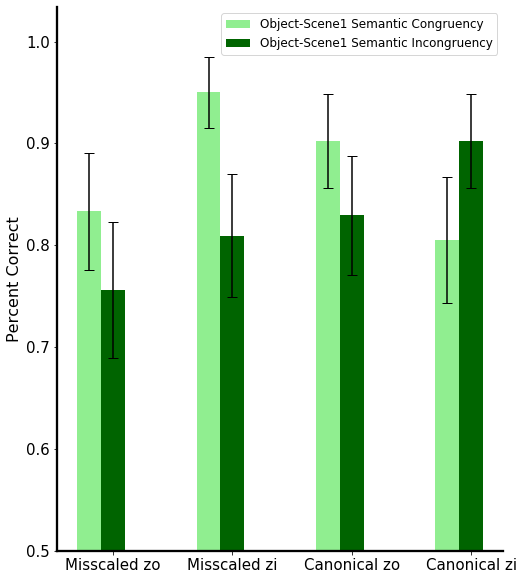

In [29]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)
#                                          Misscaled                                               Scaled
#                                zo                          zi                         zo                       zi
Acc_objSemCong =   [misscaled_zo_objSemCong_acc, misscaled_zi_objSemCong_acc, scaled_zo_objSemCong_acc, scaled_zi_objSemCong_acc]
yerr_objSemCong =  [misscaled_zo_objSemCong_sem, misscaled_zi_objSemCong_sem, scaled_zo_objSemCong_sem, scaled_zi_objSemCong_sem]

Acc_objSemIncong =   [misscaled_zo_objSemIncong_acc, misscaled_zi_objSemIncong_acc, scaled_zo_objSemIncong_acc, scaled_zi_objSemIncong_acc]
yerr_objSemIncong =  [misscaled_zo_objSemIncong_sem, misscaled_zi_objSemIncong_sem, scaled_zo_objSemIncong_sem, scaled_zi_objSemIncong_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_objSemCong, width, color='lightgreen', label='Object-Scene1 Semantic Congruency', yerr=yerr_objSemCong, capsize=5)
plt.bar(x, Acc_objSemIncong, width, color='darkgreen', label='Object-Scene1 Semantic Incongruency', yerr=yerr_objSemIncong, capsize=5)
plt.xticks(x, ['Misscaled zo', 'Misscaled zi', 'Canonical zo', 'Canonical zi'], fontsize='15')
plt.ylim(0.50)
plt.yticks(fontsize=15) 
plt.ylabel("Percent Correct", fontsize=16)
plt.legend(loc=1, fontsize=12)
plt.show()

## RT

CREATE DIFF DF - ONLY INCLUDE CORRECT TRIALS

WITHIN PARTICIPANT SEM

In [30]:
final_data_correctOnly = final_data.loc[final_data['accuracy']==1]

np.mean(np.array(final_data_correctOnly['RT']))

1253.1935483870968

In [31]:
# data split by object-scene size congruency aka scene zoom 

zo_df_CO = final_data_correctOnly.loc[final_data_correctOnly['scene1ZoomName']=='zo']
zi_df_CO = final_data_correctOnly.loc[final_data_correctOnly['scene1ZoomName']=='zi']

zo_RT = np.mean(np.array(zo_df_CO['RT']))
zi_RT = np.mean(np.array(zi_df_CO['RT']))


zo_RT, zi_RT

(1249.3357664233577, 1256.9154929577464)

In [32]:
misscaled_zo_CO = zo_df_CO.loc[zo_df_CO['misscaled'] =='misscaled'] 
misscaled_zi_CO = zi_df_CO.loc[zi_df_CO['misscaled'] =='misscaled']
misscaled_CO = misscaled_zo_CO.append(misscaled_zi_CO)

scaled_zo_CO = zo_df_CO.loc[zo_df_CO['misscaled'] =='scaled'] 
scaled_zi_CO = zi_df_CO.loc[zi_df_CO['misscaled'] =='scaled']
scaled_CO = scaled_zo_CO.append(scaled_zi_CO)

In [33]:
misscaled_zo_objSemCong_CO = misscaled_zo_CO.loc[misscaled_zo_CO["objectScene1SemanticCongruency"]==1]
misscaled_zo_objSemIncong_CO = misscaled_zo_CO.loc[misscaled_zo_CO["objectScene1SemanticCongruency"]==0]

misscaled_zo_objSemCong_RT = np.mean(np.array(misscaled_zo_objSemCong_CO['RT']))
misscaled_zo_objSemIncong_RT = np.mean(np.array(misscaled_zo_objSemIncong_CO['RT']))

misscaled_zo_objSemCong_RT_sem = sem(np.array(misscaled_zo_objSemCong_CO['RT']))
misscaled_zo_objSemIncong_RT_sem = sem(np.array(misscaled_zo_objSemIncong_CO['RT']))


misscaled_zi_objSemCong_CO = misscaled_zi_CO.loc[misscaled_zi_CO["objectScene1SemanticCongruency"]==1]
misscaled_zi_objSemIncong_CO = misscaled_zi_CO.loc[misscaled_zi_CO["objectScene1SemanticCongruency"]==0]

misscaled_zi_objSemCong_RT = np.mean(np.array(misscaled_zi_objSemCong_CO['RT']))
misscaled_zi_objSemIncong_RT = np.mean(np.array(misscaled_zi_objSemIncong_CO['RT']))

misscaled_zi_objSemCong_RT_sem = sem(np.array(misscaled_zi_objSemCong_CO['RT']))
misscaled_zi_objSemIncong_RT_sem = sem(np.array(misscaled_zi_objSemIncong_CO['RT']))


# scaled
scaled_zo_objSemCong_CO = scaled_zo_CO.loc[scaled_zo_CO["objectScene1SemanticCongruency"]==1]
scaled_zo_objSemIncong_CO = scaled_zo_CO.loc[scaled_zo_CO["objectScene1SemanticCongruency"]==0]

scaled_zo_objSemCong_RT = np.mean(np.array(scaled_zo_objSemCong_CO['RT']))
scaled_zo_objSemIncong_RT = np.mean(np.array(scaled_zo_objSemIncong_CO['RT']))

scaled_zo_objSemCong_RT_sem = sem(np.array(scaled_zo_objSemCong_CO['RT']))
scaled_zo_objSemIncong_RT_sem = sem(np.array(scaled_zo_objSemIncong_CO['RT']))


scaled_zi_objSemCong_CO = scaled_zi_CO.loc[scaled_zi_CO["objectScene1SemanticCongruency"]==1]
scaled_zi_objSemIncong_CO = scaled_zi_CO.loc[scaled_zi_CO["objectScene1SemanticCongruency"]==0]

scaled_zi_objSemCong_RT = np.mean(np.array(scaled_zi_objSemCong_CO['RT']))
scaled_zi_objSemIncong_RT = np.mean(np.array(scaled_zi_objSemIncong_CO['RT']))

scaled_zi_objSemCong_RT_sem = sem(np.array(scaled_zi_objSemCong_CO['RT']))
scaled_zi_objSemIncong_RT_sem = sem(np.array(scaled_zi_objSemIncong_CO['RT']))


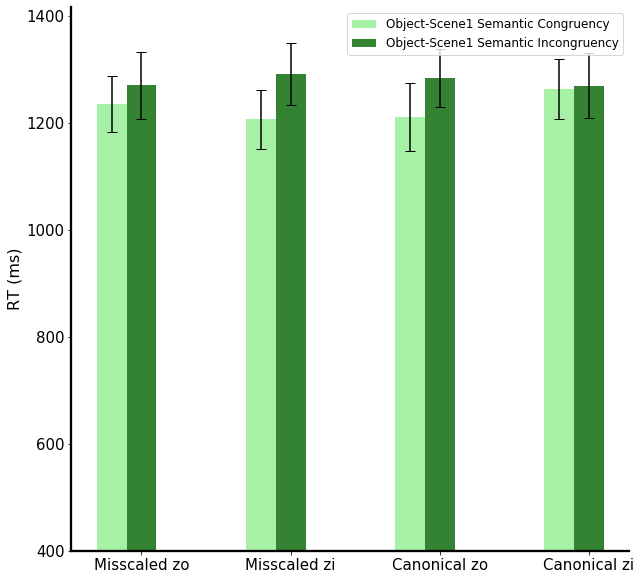

In [34]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)
#                                          Misscaled                                             Scaled
#                               zo                          zi                         zo                     zi
RT_objSemCong =   [misscaled_zo_objSemCong_RT, misscaled_zi_objSemCong_RT, scaled_zo_objSemCong_RT, scaled_zi_objSemCong_RT]
RT_objSemCong_sem = [misscaled_zo_objSemCong_RT_sem, misscaled_zi_objSemCong_RT_sem, scaled_zo_objSemCong_RT_sem, scaled_zi_objSemCong_RT_sem]

RT_objSemIncong = [misscaled_zo_objSemIncong_RT, misscaled_zi_objSemIncong_RT, scaled_zo_objSemIncong_RT, scaled_zi_objSemIncong_RT]
RT_objSemIncong_sem = [misscaled_zo_objSemIncong_RT_sem, misscaled_zi_objSemIncong_RT_sem, scaled_zo_objSemIncong_RT_sem, scaled_zi_objSemIncong_RT_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_objSemCong, width, color='lightgreen', label='Object-Scene1 Semantic Congruency', yerr=RT_objSemCong_sem, capsize=5, alpha=0.8)
plt.bar(x, RT_objSemIncong, width, color='darkgreen', label='Object-Scene1 Semantic Incongruency', yerr=RT_objSemIncong_sem, capsize=5, alpha=0.8)
plt.xticks(x, ['Misscaled zo', 'Misscaled zi', 'Canonical zo', 'Canonical zi'], fontsize='15')
plt.yticks(fontsize=15) 
plt.ylim(400)
plt.ylabel("RT (ms)", fontsize=16)
plt.legend(loc=0, fontsize=12)
plt.show()

In [35]:
RTs_correctOnly = list(final_data_correctOnly['RT']) 

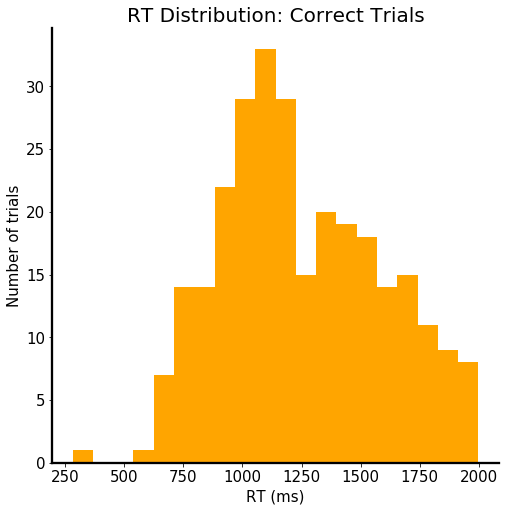

In [36]:

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)

ax.spines['top'].set_visible(False)



for axis in ['bottom','left']:

    ax.spines[axis].set_linewidth(2.3)

plt.hist(np.array(RTs_correctOnly), color='orange', bins=20)
plt.title('RT Distribution: Correct Trials', fontsize=20)
plt.xlabel('RT (ms)', fontsize=15)
plt.ylabel('Number of trials', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()